# Setup


**Imports**


In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import random
from tslearn.metrics import cdist_dtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from scipy.signal import butter, filtfilt, resample, welch

from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

rng = np.random.default_rng()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Utility functions**


In [10]:
phi = (1 + 5**0.5) / 2  # golden ratio ≈ 1.618


def fig_ax(figsize=(phi * 5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis="x", tight=True)
    return fig, ax

# Spectral feature


## Question 6


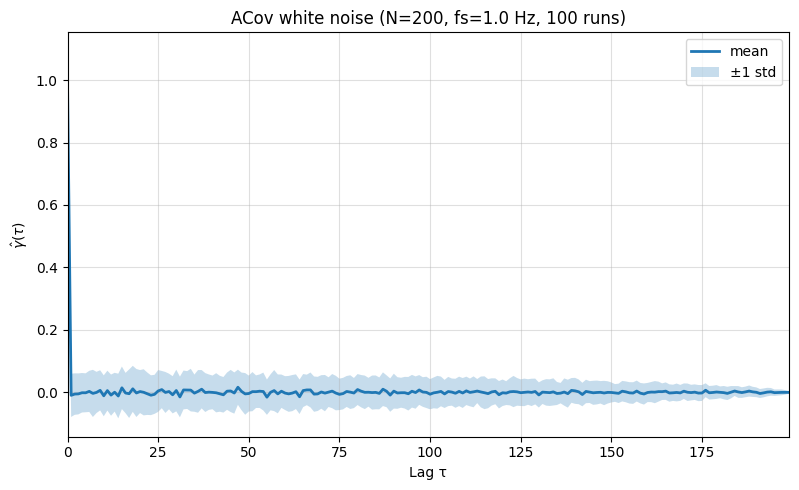

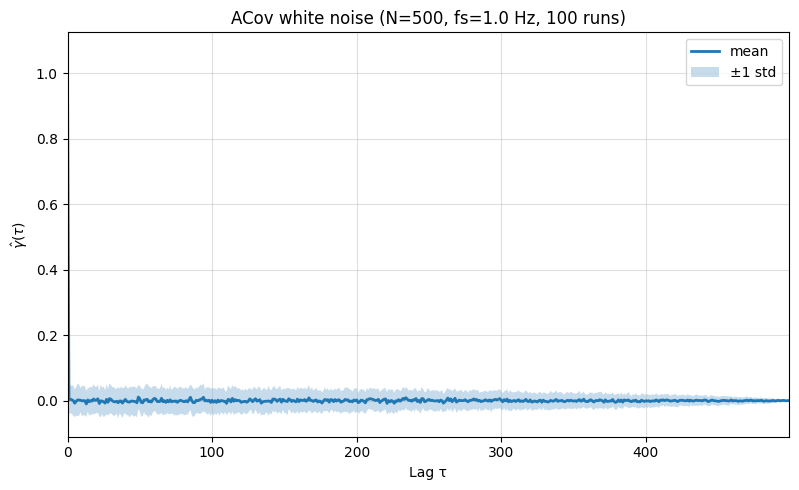

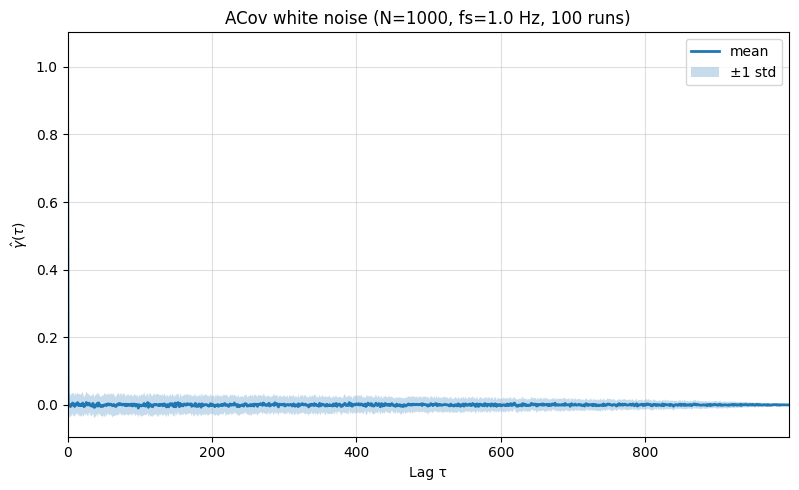

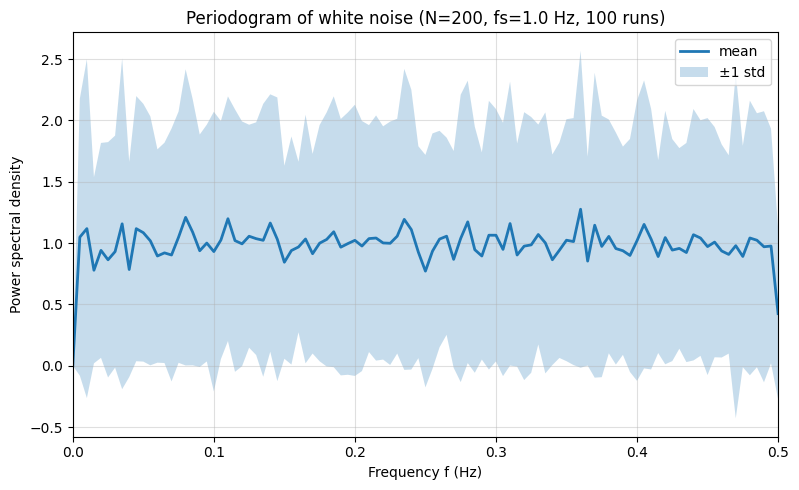

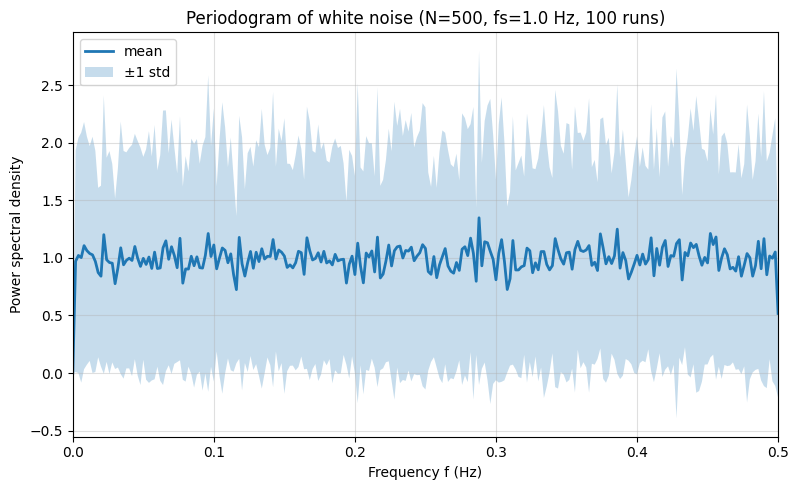

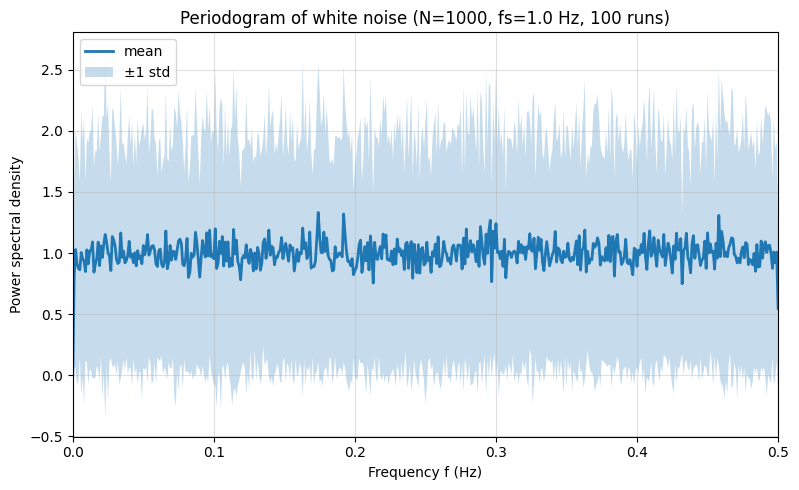

In [11]:
from statsmodels.tsa.stattools import acovf
from scipy.signal import periodogram


def sim_plot_acov_periodogram():
    # simulation parameters
    Ns = [200, 500, 1000]
    N_sim = 100
    fs = 1.0

    for N in Ns:
        # define max lag
        max_lag = N - 1
        acovs = np.zeros((N_sim, max_lag + 1))
        for s in range(N_sim):
            x = rng.normal(0, 1, N)
            # compute biased estimate because less variance
            ac = acovf(x, demean=False, fft=True, adjusted=False)
            acovs[s] = ac[: max_lag + 1]

        mu, std = acovs.mean(0), acovs.std(0)
        lags = np.arange(max_lag + 1)

        fig, ax = fig_ax()
        ax.plot(lags, mu, lw=2, label="mean")
        ax.fill_between(lags, mu - std, mu + std, alpha=0.25, label="±1 std")
        ax.set_title(f"ACov white noise (N={N}, fs={fs} Hz, {N_sim} runs)")

        plt.xlabel("Lag τ")
        plt.ylabel(r"$\hat{\gamma}(\tau)$")
        plt.grid(alpha=0.4)
        plt.legend()
        plt.tight_layout()
        # save figure in figures
        plt.savefig(f"figures/acov_white_noise_N{N}_fs{fs}_sim{N_sim}.png")
        plt.show()

    for N in Ns:
        f, _ = periodogram(np.zeros(N), fs=fs)
        Pxx = np.zeros((N_sim, len(f)))

        for s in range(N_sim):
            x = rng.normal(0, 1, N)
            f, Pxx[s] = periodogram(x, fs=fs, scaling="density", return_onesided=True)
            # rescale Pxx because periodogram returns one-sided PSD
            Pxx[s] /= 2

        mu, std = Pxx.mean(0), Pxx.std(0)

        fig, ax = fig_ax()
        ax.plot(f, mu, lw=2, label="mean")
        ax.fill_between(f, mu - std, mu + std, alpha=0.25, label="±1 std")
        ax.set_title(f"Periodogram of white noise (N={N}, fs={fs} Hz, {N_sim} runs)")
        plt.xlabel("Frequency f (Hz)")
        plt.ylabel("Power spectral density")
        plt.grid(alpha=0.4)
        plt.legend()
        plt.tight_layout()
        # save figure in figures
        plt.savefig(f"figures/periodogram_white_noise_N{N}_fs{fs}_sim{N_sim}.png")
        plt.show()


sim_plot_acov_periodogram()

## Question 9


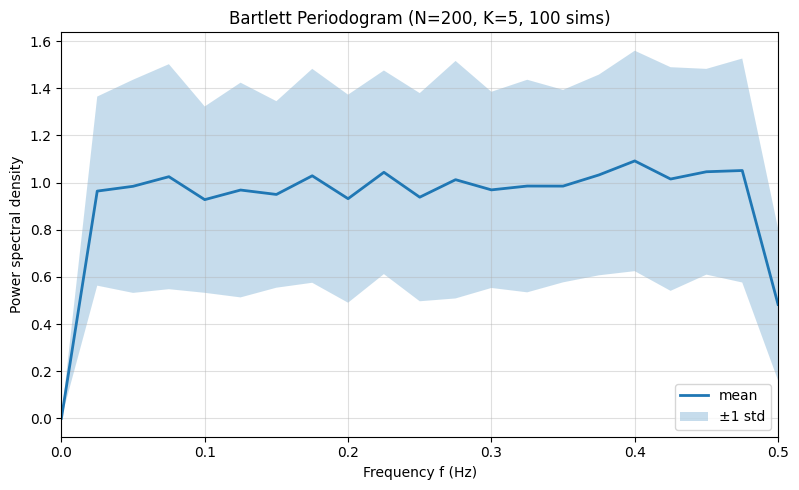

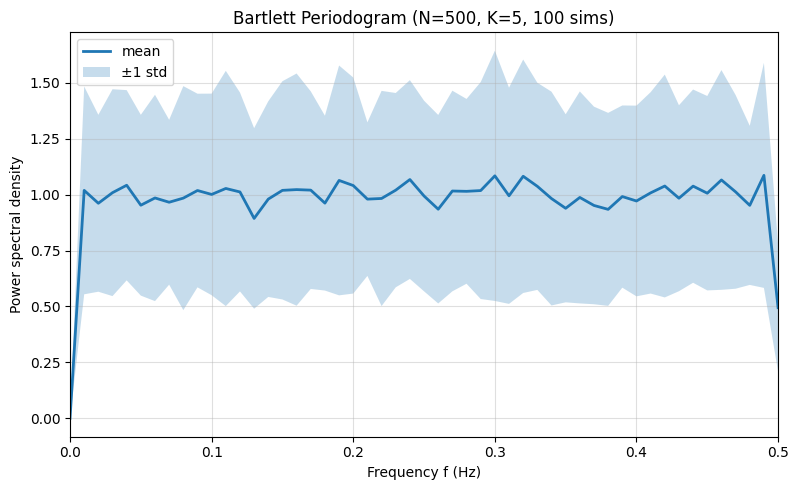

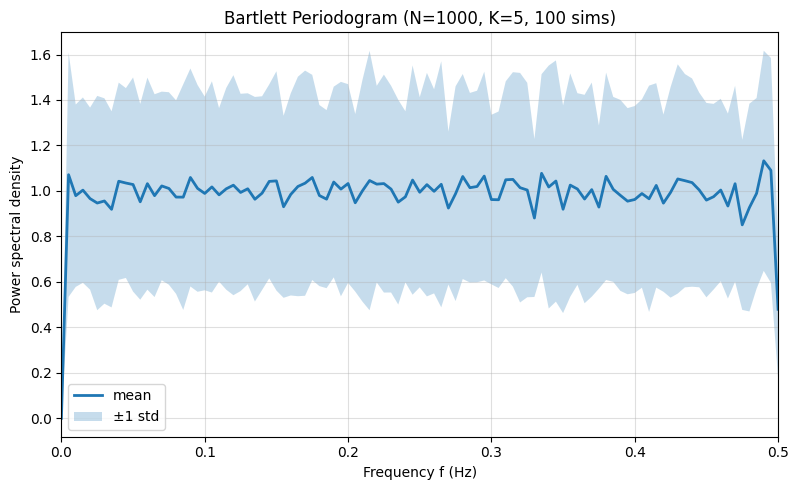

In [12]:
def sim_plot_periodogram_bartlett():
    Ns = [200, 500, 1000]
    N_sim = 100
    fs = 1.0
    K = 5

    for N in Ns:
        N_seg = N // K
        f, _ = periodogram(np.zeros(N_seg), fs=fs)  # correct frequency grid
        Pxx = np.zeros((N_sim, len(f)))

        for s in range(N_sim):
            x = rng.normal(0, 1, N)
            x_segments = np.array_split(x, K)
            Pxx_segments = []
            for segment in x_segments:
                f, Pxx_seg = periodogram(
                    segment, fs=fs, scaling="density", return_onesided=True
                )
                Pxx_seg /= 2  # rescale for one-sided PSD
                Pxx_segments.append(Pxx_seg)
            Pxx[s] = np.mean(Pxx_segments, axis=0)

        mu, std = Pxx.mean(0), Pxx.std(0)

        fig, ax = fig_ax()
        ax.plot(f, mu, lw=2, label="mean")
        ax.fill_between(f, mu - std, mu + std, alpha=0.25, label="±1 std")
        ax.set_title(f"Bartlett Periodogram (N={N}, K={K}, {N_sim} sims)")
        ax.set_xlabel("Frequency f (Hz)")
        ax.set_ylabel("Power spectral density")
        ax.grid(alpha=0.4)
        ax.legend()
        plt.tight_layout()
        # save figure in figures
        plt.savefig(
            f"figures/bartlett_periodogram_white_noise_N{N}_K{K}_fs{fs}_sim{N_sim}.png"
        )
        plt.show()


sim_plot_periodogram_bartlett()

# Dynamic time warping (DTW)


## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:

- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.


**The task** is to classify footsteps in healthy/non-healthy.


The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.


In [13]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_train.append(signal[start:end])
        y_train.append(label)


X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

In [14]:
len(X_train), len(X_test)

(168, 88)

## Question 10


In [20]:
# set all seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [21]:
# parameters
fs = 100  # Hz

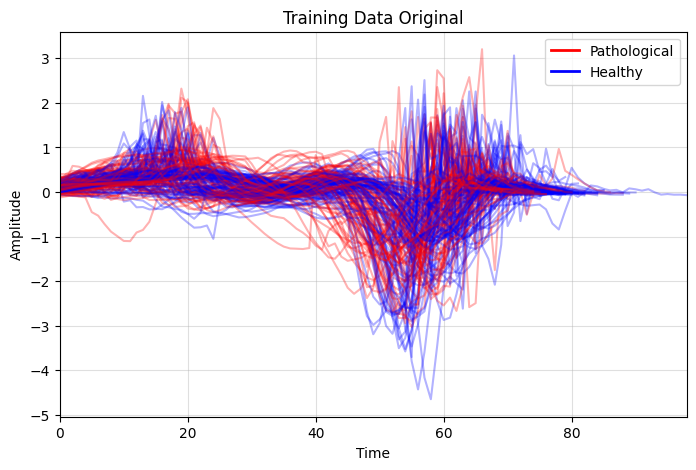

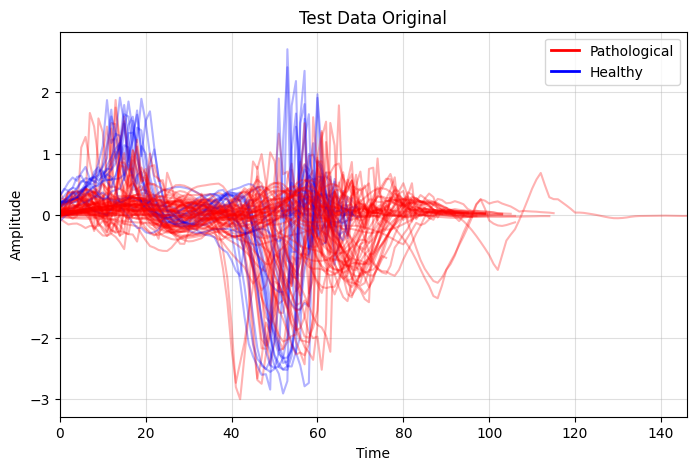

In [ ]:
from matplotlib.lines import Line2D

def plot_data(X,y,title="Data"):
    fig, ax = fig_ax()
    for i in range(len(X)):
        if y[i] == 1:
            ax.plot(X[i], color='red', alpha=0.3)
        else:
            ax.plot(X[i], color='blue', alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    # force add legend red and blue
    ax.grid(alpha=0.4)
    red_patch = Line2D([0], [0], color='red', lw=2, label='Pathological')
    blue_patch = Line2D([0], [0], color='blue', lw=2, label='Healthy')
    ax.legend(handles=[red_patch, blue_patch])
    plt.show()

plot_data(X_train, y_train, title="Training Data Original")
plot_data(X_test, y_test, title="Test Data Original")


Train set: 168 steps
Test set:  88 steps


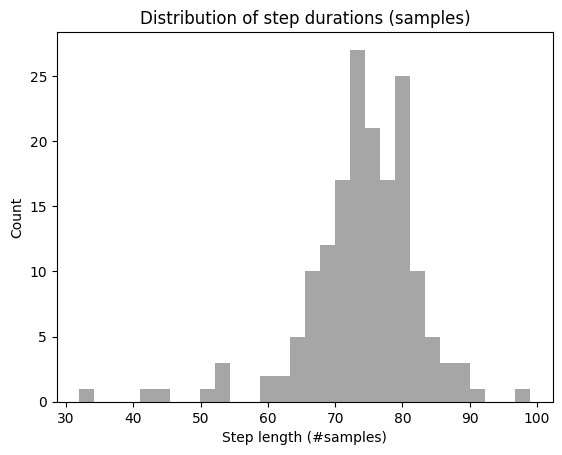

Mean length of footstep signals (train): 74
Std length of footstep signals (train): 8
Mean length of footstep signals (test): 81
Std length of footstep signals (test): 17


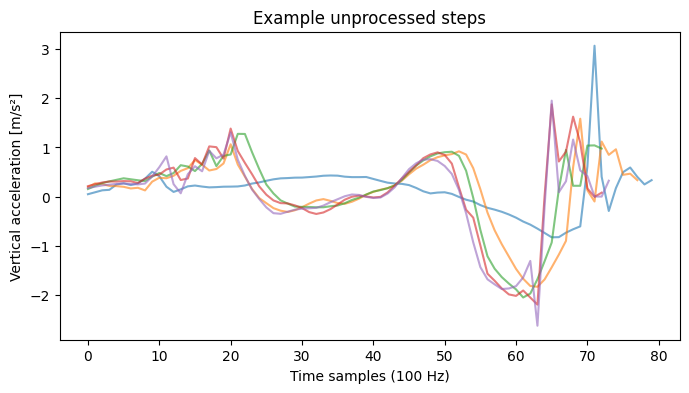

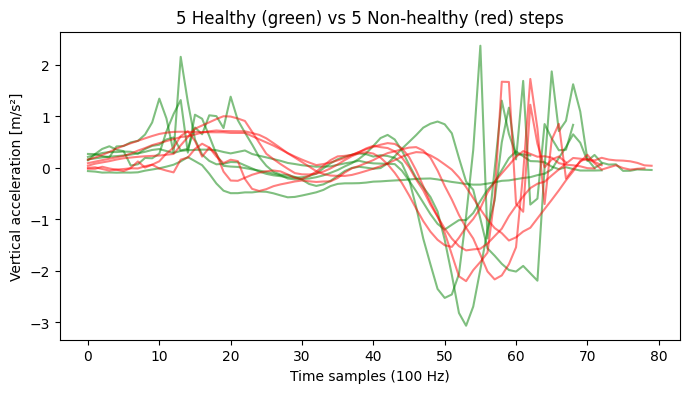

/Users/tristan/miniconda3/envs/time_series_env/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 80, using nperseg = 80
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


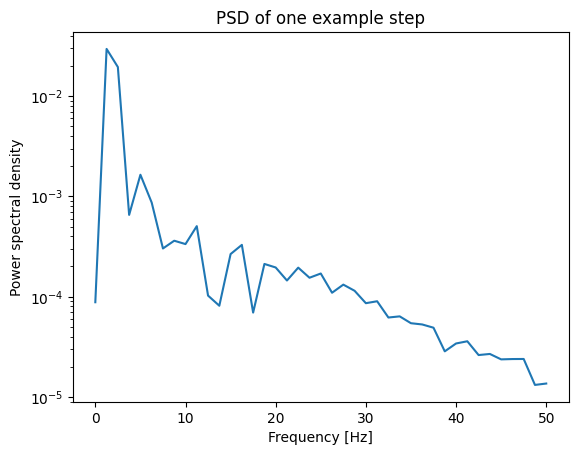

In [23]:
# basic infos
print(f"Train set: {len(X_train)} steps")
print(f"Test set:  {len(X_test)} steps")

# distribution of step lengths
train_lengths = [len(x) for x in X_train]
plt.hist(train_lengths, bins=30, color="gray", alpha=0.7)
plt.xlabel("Step length (#samples)")
plt.ylabel("Count")
plt.title("Distribution of step durations (samples)")
plt.show()

# mean and std of step lengths
mean_length_train = int(np.mean([len(x) for x in X_train]))
std_length_train = int(np.std([len(x) for x in X_train]))
mean_length_test = int(np.mean([len(x) for x in X_test]))
std_length_test = int(np.std([len(x) for x in X_test]))
print(f"Mean length of footstep signals (train): {mean_length_train}")
print(f"Std length of footstep signals (train): {std_length_train}")
print(f"Mean length of footstep signals (test): {mean_length_test}")
print(f"Std length of footstep signals (test): {std_length_test}")


# plot some steps
plt.figure(figsize=(8, 4))
for i, x in enumerate(X_train[:5]):
    plt.plot(x, alpha=0.6)
plt.title("Example unprocessed steps")
plt.xlabel("Time samples (100 Hz)")
plt.ylabel("Vertical acceleration [m/s²]")
plt.show()

# plot healthy vs non-healthy steps
healthy_steps = [X_train[i] for i in range(len(X_train)) if y_train[i] == 0]
patho_steps = [X_train[i] for i in range(len(X_train)) if y_train[i] == 1]

plt.figure(figsize=(8, 4))
n_steps_to_plot = 5
for x in random.sample(healthy_steps, n_steps_to_plot):
    plt.plot(x, color="green", alpha=0.5)
for x in random.sample(patho_steps, n_steps_to_plot):
    plt.plot(x, color="red", alpha=0.5)
plt.title(
    f"{n_steps_to_plot} Healthy (green) vs {n_steps_to_plot} Non-healthy (red) steps"
)
plt.xlabel("Time samples (100 Hz)")
plt.ylabel("Vertical acceleration [m/s²]")
plt.show()

# plot psd of one example step
x = X_train[0]
f, Pxx = welch(x, fs=fs)
plt.semilogy(f, Pxx)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power spectral density")
plt.title("PSD of one example step")
plt.show()

In [24]:
# processing
def lowpass_filter(x, fs=100, cutoff=15, order=4):
    b, a = butter(order, cutoff / (fs / 2), btype="low")
    return filtfilt(b, a, x)


def preprocess_step(x, fs=100):
    x = lowpass_filter(x, fs=fs, cutoff=15)  # denoise
    x = x - np.mean(x)  # center
    x = x / (np.std(x) + 1e-8)  # normalize
    x = resample(x, mean_length_train)  # resample to mean train length
    return x


def preprocess_dataset(X, fs=100):
    return [preprocess_step(x, fs=fs) for x in X]


# process datasets
X_train_proc = preprocess_dataset(X_train)
X_test_proc = preprocess_dataset(X_test)

print(
    f"After preprocessing, all steps have mean train length length: {len(X_train_proc[0])} samples"
)

# convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

After preprocessing, all steps have mean train length length: 74 samples


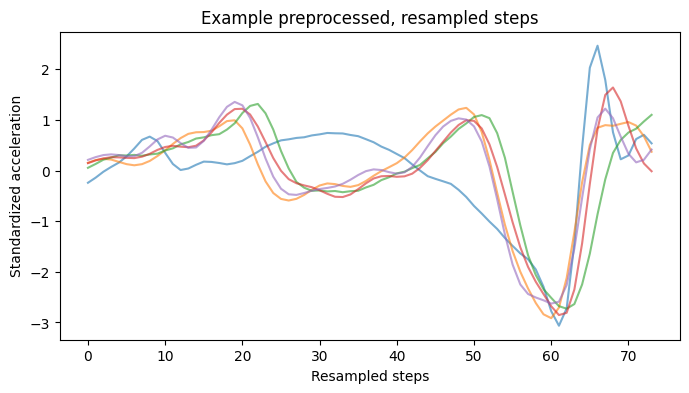

In [25]:
plt.figure(figsize=(8, 4))
for i in range(5):
    plt.plot(X_train_proc[i], alpha=0.6)
plt.title("Example preprocessed, resampled steps")
plt.xlabel("Resampled steps")
plt.ylabel("Standardized acceleration")
plt.show()

In [26]:
print("Computing DTW distance matrix (train–train)...")
D_train = cdist_dtw(X_train_proc)  # shape (N_train, N_train)

print("Computing DTW distance matrix (test–train)...")
D_test = cdist_dtw(X_test_proc, X_train_proc)  # shape (N_test, N_train)

Computing DTW distance matrix (train–train)...
Computing DTW distance matrix (test–train)...


In [54]:
k_values = [i for i in range(1, 21)] + [10*i for i in range(3, 8)]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
avg_f1_scores = []

best_k, best_f1 = None, 0
for k in k_values:
    fold_f1 = []
    for train_idx, val_idx in skf.split(D_train, y_train):
        D_tr = D_train[np.ix_(train_idx, train_idx)]
        D_val = D_train[np.ix_(val_idx, train_idx)]

        knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
        knn.fit(D_tr, y_train[train_idx])
        y_pred = knn.predict(D_val)
        fold_f1.append(f1_score(y_train[val_idx], y_pred))

    mean_f1 = np.mean(fold_f1)
    avg_f1_scores.append(mean_f1)
    print(f"k={k}: mean F1={mean_f1:.3f}")
    if mean_f1 > best_f1:
        best_f1, best_k = mean_f1, k

print(f"\nOptimal k={best_k}, mean CV-F1={best_f1:.3f}")

k=1: mean F1=0.880
k=2: mean F1=0.840
k=3: mean F1=0.875
k=4: mean F1=0.854
k=5: mean F1=0.856
k=6: mean F1=0.865
k=7: mean F1=0.884
k=8: mean F1=0.873
k=9: mean F1=0.882
k=10: mean F1=0.874
k=11: mean F1=0.884
k=12: mean F1=0.853
k=13: mean F1=0.861
k=14: mean F1=0.814
k=15: mean F1=0.820
k=16: mean F1=0.781
k=17: mean F1=0.791
k=18: mean F1=0.785
k=19: mean F1=0.784
k=20: mean F1=0.707
k=30: mean F1=0.695
k=40: mean F1=0.676
k=50: mean F1=0.635
k=60: mean F1=0.617
k=70: mean F1=0.566

Optimal k=7, mean CV-F1=0.884


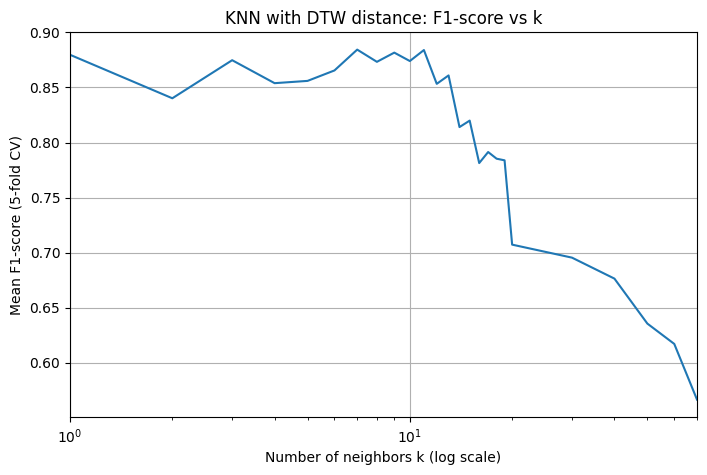

In [55]:
# plot F1-score vs k logscale
fig, ax = fig_ax()

ax.plot(k_values, avg_f1_scores)
ax.set_xscale("log")
ax.set_xlabel("Number of neighbors k (log scale)")
ax.set_ylabel("Mean F1-score (5-fold CV)")
ax.set_title("KNN with DTW distance: F1-score vs k")
ax.grid()
plt.show()

In [56]:
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="precomputed")
knn_final.fit(D_train, y_train)
y_pred_test = knn_final.predict(D_test)

test_f1 = f1_score(y_test, y_pred_test)
print(f"Test F-score = {test_f1:.3f}")

Test F-score = 0.523


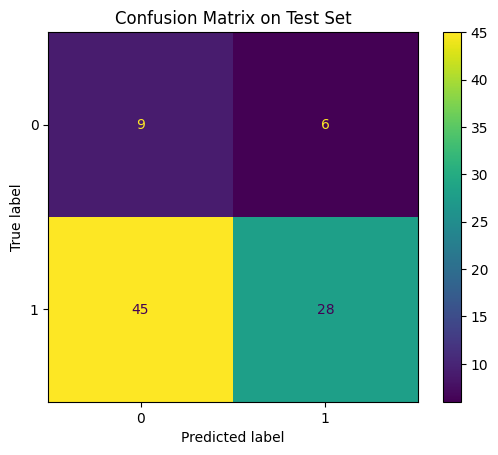

In [57]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()


## Question 11


In [58]:
# Predict and compute per-sample correctness
y_pred_test = knn_final.predict(D_test)
errors = y_pred_test != y_test

# Get indices of misclassified steps by true class
wrong_healthy = np.where((y_test == 0) & errors)[
    0
]  # true healthy misclassified as non-healthy
wrong_patho = np.where((y_test == 1) & errors)[
    0
]  # true non-healthy misclassified as healthy

In [59]:
import random

bad_h = random.choice(wrong_healthy) if len(wrong_healthy) > 0 else None
bad_p = random.choice(wrong_patho) if len(wrong_patho) > 0 else None

print("Misclassified healthy index:", bad_h)
print("Misclassified non-healthy index:", bad_p)

Misclassified healthy index: 33
Misclassified non-healthy index: 1


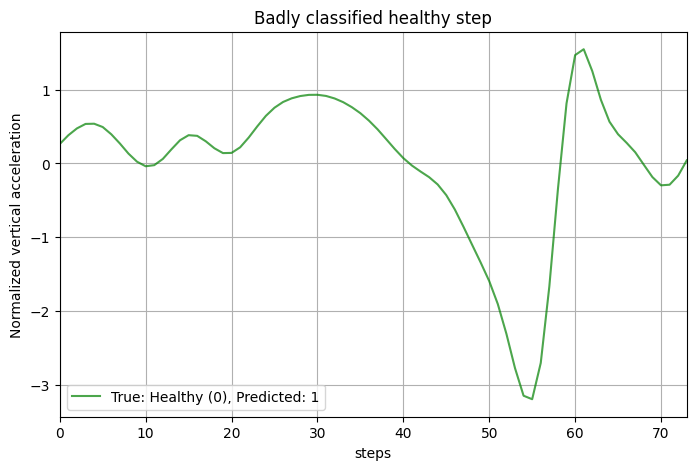

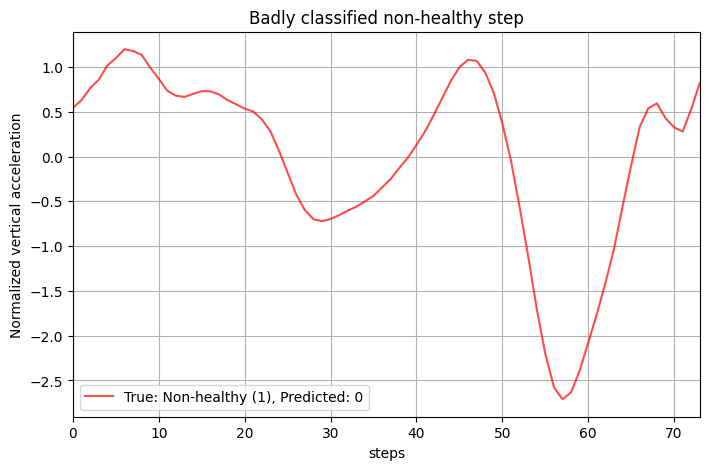

In [62]:
import matplotlib.pyplot as plt

# Misclassified healthy
fig, ax = fig_ax()
if bad_h is not None:
    ax.plot(
        X_test_proc[bad_h],
        color="green",
        alpha=0.7,
        label=f"True: Healthy (0), Predicted: {y_pred_test[bad_h]}",
    )
    ax.set_xlabel("steps")
    ax.set_ylabel("Normalized vertical acceleration")
    ax.set_title("Badly classified healthy step")
    ax.grid()
    ax.legend(loc="lower left")
    plt.savefig(
            f"figures/badly_classified_healthy_step.png"
        )
    plt.show()

# Misclassified non-healthy
fig, ax = fig_ax()
if bad_p is not None:
    ax.plot(
        X_test_proc[bad_p],
        color="red",
        alpha=0.7,
        label=f"True: Non-healthy (1), Predicted: {y_pred_test[bad_p]}",
    )
    ax.set_xlabel("steps")
    ax.set_ylabel("Normalized vertical acceleration")
    ax.set_title("Badly classified non-healthy step")
    ax.legend(loc="lower left")
    ax.grid()
    plt.savefig(
            f"figures/badly_classified_non_healthy_step.png"
        )
    plt.show()